In [1]:
%pylab inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("machine-learning"))

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'machine-learning'

In [ ]:
import h5py 
from functools import reduce
def hdf5(path, data_key = "data", target_key = "target", flatten = True):
    """
        loads data from hdf5: 
        - hdf5 should have 'train' and 'test' groups 
        - each group should have 'data' and 'target' dataset or spcify the key
        - flatten means to flatten images N * (C * H * W) as N * D array
    """
    with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        X_tr = train.get(data_key)[:]
        y_tr = train.get(target_key)[:]
        test = hf.get('test')
        X_te = test.get(data_key)[:]
        y_te = test.get(target_key)[:]
        if flatten:
            X_tr = X_tr.reshape(X_tr.shape[0], reduce(lambda a, b: a * b, X_tr.shape[1:]))
            X_te = X_te.reshape(X_te.shape[0], reduce(lambda a, b: a * b, X_te.shape[1:]))
    return X_tr, y_tr, X_te, y_te

In [ ]:
X_tr, y_tr, X_te, y_te = hdf5("machine-learning/usps.h5")
X_tr.shape, X_te.shape
#I will choose how to split training and test
X_comb=np.append(X_tr,X_te,0)#9298 obs x 256 bits
y_comb=np.append(y_tr,y_te)
print(len(y_comb))
print(len(X_comb[:,1]))
print(len(X_comb[1,:]))

9298
9298
256


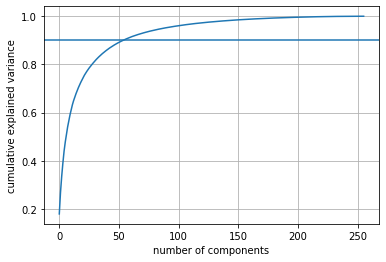

In [ ]:
from sklearn.decomposition import PCA
pca=PCA().fit(X_comb)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.axhline(y=0.9)
plt.grid()


In [ ]:
pca=PCA(n_components=100).fit(X_comb)
a=np.cumsum(pca.explained_variance_ratio_)
a[-1]


0.95981216

In [ ]:
class Cross_Validation:
    @staticmethod
    def partition(X_train,y_train,k=5):
        Xrows = size(X_train[:,1])#6229
        Xcols = size(X_train[1,:])#256
        print('Xrows ' + str(Xrows) + " Xcols " + str(Xcols))
        print("Add y_train to X_train before shuffling")
        X_copy=np.zeros((Xrows,Xcols+1),dtype=np.float32)
        X_copy[:,256] = y_train
        X_copy[:,0:256] = X_train
        Xcols = size(X_copy[1,:])#256 cols
        Xrows = size(X_copy[:,1])#6229 samples rows
        print('Xrows ' + str(Xrows) + " Xcols " + str(Xcols))#6229x256 --> 6229x 257
        #let us append the results else am fucking stuff up
        #np.random.shuffle(X_copy) # Shuffle all rows#
    
        folds = np.array_split(X_copy, k)
        length=size(X_copy[1,:])-1
#print(size(folds[1][:,1]))#1246 samples
#print(size(folds[1][1,:]))#257 cols
#ytest = folds[i][:,256]

    # some print functions to help you debug
    #print(f'Fold {i}')
    #print(f'xtest shape  : {xtest.shape}')
    #print(f'ytest shape  : {ytest.shape}')
    #print(f'xtrain shape : {xtrain.shape}')
    #print(f'ytrain  : {ytrain.shape}\n')
        return folds,length

In [ ]:
from random import randint
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

class KernelPegasos():
    # kernels and loss function
    ## Kernelised Pegasos with different kernel support:- "linear","guassian", "polynomial"
    def __init__(self,T=10,lamb=1e-3,kernel="gaussian"):
        ##lamb --> regularisation param
        ## loss_func can be "hinge loss" or "logistic loss"
        self.kernel_list=("gaussian","polynomial", "linear")
        self.T=T
        self.pos_cl = 1
        self.neg_cl = -1
        self.lamb = lamb


        #loss function
        #self.loss_func_list=("hinge","log","zeroone")
        #if loss_func not in self.loss_func_list:
         #   raise Exception("Loss function not found!!\n")
            #hinge
        #if loss_func==self.loss_func_list[0]:
        #    self.obj = self.update_hinge
        #elif loss_func==self.loss_func_list[2]:
         #   self.obj = self.update_zeroone
        #else:#log
         #   self.obj = self.update_log


        #kernel 
        if kernel not in self.kernel_list:
            raise Exception("Kernel not found!!\n")
        elif kernel == self.kernel_list[0]:
            self.kernel = self.gaussian_kernel
        elif kernel ==self.kernel_list[1]:
           self.kernel = self.polynomial_kernel
        else:
           self.kernel = self.linear_kernel
            
    #Define update functions
    def update_hinge(self,score,yi,xi,eta,w):
        if yi*score < 1:
            return (1 - eta*self.lamb)*w + eta*yi*xi
        else:
            return (1 - eta*self.lamb)*w

    def update_log(self,score,yi,xi,eta,w):
        return (1 - eta*self.lamb)*w + xi*eta*yi / (1+expit(yi*score))

    def linear_kernel(self,x,y):
        return np.dot(x,y)

    def polynomial_kernel(self,x, y, p=3):
        return (1 + np.dot(x, y)) ** p

    def gaussian_kernel(self,x, y, variance=0.25):
        #sigma**2 is variance
        mean=np.linalg.norm(x-y)**2
        return np.exp(-mean / (2 * variance))

            
    def fit(self,x,y):
        ## Complexity :- O(#epoch * #train samples)
        try:
            x=x.toarray()
        except AttributeError:
            pass
        x = np.insert(x,x.shape[1],1,axis=1)
        m,n = x.shape[0],x.shape[1] ## m --> number of samples , n --> number of features
        self.alpha = np.zeros((self.T+1,m))#iterations,samples
        y = list(y)
        classes = sorted(set(y))#encode firs 
        if len(classes) != 2:
            raise Exception("Not a binary classification!!\n")

        for t in range(self.T):
            step = 1. / (self.lamb*(t+1))
            #-- Choose a random xit , yit
            it = np.random.randint(0,m)#m is number of samples (lenght y)
            #j = self.init_index
            xit, yit = x[it], y[it]
            #---For all j different than it , set the next alpha[j] to the previous 1
            for j in range(m):
                if j!=it:
                    self.alpha[t+1,j]=self.alpha[t,j]
            #Perform the sum over j of the following 
            sum_=0.0
            for j in range(m):
                sum_+=self.alpha[t,j]*self.kernel(xit,x[j])*y[j]#alpha weights
            sum_*=yit*step
            if sum_<1:
                self.alpha[t+1,it] = self.alpha[t,it]+1
            else:
                self.alpha[t+1,it]=self.alpha[t,it]
        self.alpha = self.alpha[self.T]
        self.y_train = y
        self.x_train = x
        print("fitting Complete!!\n")
        return self

    def predict(self,xtest):
        ## complexity O(#support vectors * #test samples)
        try:
            xtest=xtest.toarray()
        except AttributeError:
            pass
        xtest = np.insert(xtest,xtest.shape[1],1,axis=1)
        l = xtest.shape[0]#size of ytest
        m = self.alpha.shape[0]#size of ytrain
        scores = np.zeros(l)
        for i in range(l):
            score=0.0
            for k in range(m):
                if self.alpha[k]>0:
                    score+=self.alpha[k]*self.kernel(xtest[i],self.x_train[k])*self.y_train[k]
            scores[i]=score
        ypred = np.select([scores>0.0, scores<=0.0], [self.pos_cl, self.neg_cl])
        return ypred#y_pred -1 1 

    def score(self,X,y_test):
        y_pred= self.predict(X)
        errors=0
        for i in range(size(y_pred)):
            if(y_pred[i]!=y_test[i]):
                errors+=1
        zerooneloss = errors/len(y_test)        
        accuracy =  1- zerooneloss#0-1 mean loss
        return accuracy
    

In [ ]:
#one hot encode labels
#encoded_labels = []
#for i in range(len(y_tr)):
 # naked = [0,0,0,0,0,0,0,0,0,0]
  #naked[y_tr[i]] = 1
  #encoded_labels.append(naked)

import numpy as np

lr = [0,1,2,3,4,5,6,7,8,9]#from 0 to 9
#for label in range(10):
 #   one_hot = (lr==label).astype(np.int)
  #  print("label: ", label, " in one-hot representation: ", one_hot)


#We have 7291 numbers. For each number create 9 col.
y_combined = np.zeros((y_comb.shape[0], y_comb.max()+1), dtype=np.float32)#7291 rows,9cols
#y_train[np.arange(y_tr.shape[0]), y_tr] = 1#7291,0 for each row , set the ytr col ot 1, xth row pops y_tr place 1
#ranges from 0->7290 ,0->9
y0, y1, y2, y3, y4, y5, y6, y7, y8, y9 = [],[],[],[],[],[],[],[],[],[]


for row in range(y_comb.shape[0]): #from 0 to 7291 
  for col in range(y_comb.max()+1):
    if(col == y_comb[row]):
      y_combined[row, col] = 1#col range from 0 to 9
      eval('y'+str(col)).append(int(1))
    else:
      y_combined[row, col] = -1
      eval('y'+str(col)).append(int(-1))

#print(np.arange(y_tr.shape[0]))
#print(y_tr)
#[-1 if x==0 else x for x in y_train]
print(y_comb[3])
print(y_combined[3,:])#get row 1 

y0 = np.asarray(y0)
y1 = np.asarray(y1)
y2 = np.asarray(y2)
y3 = np.asarray(y3)
y4 = np.asarray(y4)
y5 = np.asarray(y5)
y6 = np.asarray(y6)
y7 = np.asarray(y7)
y8 = np.asarray(y8)
y9 = np.asarray(y9)


7
[-1. -1. -1. -1. -1. -1. -1.  1. -1. -1.]


In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_comb,currentLabel,test_size=0.33,random_state=42)
def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) 
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

In [ ]:
def metrics(y_pred,y_test):
    tp,tn,fp,fn=0,0,0,0
    for i in range(size(y_pred)):
        if(y_pred[i]==y_test[i]):
            if(y_test[i]==-1):#negative
                tn+=1
            else:
                tp+=1                
        elif(y_pred[i]!=y_test[i]):
            if(y_test[i]==-1):#negative
                fp+=1
            else:
                fn+=1
        #accuracy is 1-zerooneloss
    if((tp+fp)==0):
        precision=0
    else:
        precision=tp/(tp+fp)#best for large sample neg -- p detect positive values -- total pred pos
        ##if i get positive-pred --> almost sure it will be
        ##if 0 --> all have been recognized as negative !!
    if((tn+fn)==0):
        fnratio = 0
    else:
        fnratio=fn/(tn+fn)
        ##
    if((tp+fn)==0):##no positive cases in input data
        recall=0
    else:
        recall=tp/(tp+fn)
    
    if(((2*tp+fp+fn))==0):
        f1score=0
    else:
        f1score=2*tp/(2*tp+fp+fn)#all have been rec as engative
    if((tp+fp)+(tn+fn)==0):
        zerooneloss=0
    else:
        zerooneloss=(fp+fn)/(tp+fp+tn+fn)#or sum of errors/len(y_test)
    #tp+tn
    accuracy = 1-zerooneloss
    print("FN ratio: ", fnratio,"(",np.round(fnratio*100, 2),"%)")
    print("FP ratio: ", 1-precision,"(",np.round((1-precision)*100, 2),"%)")
    print("Precision: ", precision,"(",np.round(precision*100, 2),"%)")
    print("Recall: ", recall,"(",np.round(recall*100, 2),"%)")
    print("Accuracy: ", accuracy,"(",np.round(accuracy*100, 2),"%)")
    print("f1score: ", f1score,"(",np.round(f1score*100, 2),"%)")
    return precision,f1score

In [ ]:
#50 diim
pca=PCA(n_components=50)

In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
#Do a big loop 0->9 FINAL
#80 rows -- around 4h30
import warnings
warnings.filterwarnings('ignore')

import time
#count=-1
cv=5
count=-1

lim_num_classes=10
# Choose hyperparams
#ite=[10]
#lmdb=[1e-5,1e-4]
ite = [10,100,1000,1500]
lmdb=[1e-5,1e-4]
#4x3x10=120
rows = size(ite)*size(lmdb)*lim_num_classes
results = np.zeros((rows , 2+3+1+1)) # 3 (2 hyper+acc+prec+f1+time+testlabel)* number of ite
precision_scores = np.zeros(cv)
f1_scores = np.zeros(cv)
acc_scores=np.zeros(cv)

for j in range (0,lim_num_classes):
    currentLabel=eval('y'+str(j)) #this is label i -- have 
    print("-------------" + 'y' + str(j) +"-------------------" )
    #Split in train test
    X_train, X_test, y_train, y_test = non_shuffling_train_test_split(X_comb,currentLabel,test_size=0.33)

#k_fold = KFold(n_splits=5)
    folds,length= Cross_Validation.partition(X_train,y_train,k=cv)
#folds,length= Cross_Validation.partition(X_comb,currentLabel,k=cv)

    print('Performing ' + str(cv) + '-Fold validation')
    col1no=-1

    for t in ite:
        col1no+=1
        col2no=-1
        for lm in lmdb:
                col2no+=1
                col3no=-1
                scores = np.zeros(cv)   #5 times cross val
                count+=1
                elaspedt=0
#        for id_train, id_test in k_fold.split(X_train):    
                for kth in range (cv):
                    xsubtest = folds[kth][:,:length] # Set ith fold to be test
                    ysubtest = folds[kth][:,length]
                    new_folds = np.row_stack(np.delete(folds,kth,0))
                    xsubtrain = new_folds[:,:length]
                    xfinsubtrain=pca.fit_transform(xsubtrain)
                    ysubtrain = new_folds[:,length]
                    col3no += 1
                    svc = KernelPegasos(T=t, lamb=lm)
            #xsubtrain, ysubtrain = X_train[id_train], y_train[id_train]
            #xsubtest, ysubtest = X_train[id_test], y_train[id_test]
                    start = time.time()     
                    svc.fit(xfinsubtrain, ysubtrain)
                    acc_scores[col3no] = svc.score(pca.transform(xsubtest), ysubtest)#vector 5 
                    end = time.time()
                    precision,f1score=metrics(svc.predict(pca.transform(xsubtest)),ysubtest)#precision f1score
                    precision_scores[col3no] = precision
                    f1_scores[col3no] = f1score
                    elaspedt+=(end-start)
            # get the mean -- get 1 value (cv estimate)
                #avg CV time 
                mean_acc = acc_scores.mean()#will get nxm mean scores --> get
                mean_precision=precision_scores.mean()
                mean_f1= f1_scores.mean()

                results[count] = [j, t, lm, mean_acc,mean_precision,mean_f1, elaspedt] #3rd col put mean(scores)
                print('Print row ' + str(count) + ' For number = ' + str(j) + ' with T=' + str(t) 
                +' and lambda=' + str(lm) + ' avg_acc=' + str(mean_acc)+ ' av_precision=' + str(mean_precision)
                +' avg_f1_score=' + str(mean_f1)+ ' time ' +str(elaspedt))

-------------y0-------------------
Xrows 6229 Xcols 256
Add y_train to X_train before shuffling
Xrows 6229 Xcols 257
Performing 5-Fold validation
fitting Complete!!

FN ratio:  0.2030497592295345 ( 20.3 %)
FP ratio:  1 ( 100 %)
Precision:  0 ( 0 %)
Recall:  0.0 ( 0.0 %)
Accuracy:  0.7969502407704655 ( 79.7 %)
f1score:  0.0 ( 0.0 %)
fitting Complete!!

FN ratio:  0.06470028544243578 ( 6.47 %)
FP ratio:  0.15897435897435896 ( 15.9 %)
Precision:  0.841025641025641 ( 84.1 %)
Recall:  0.7068965517241379 ( 70.69 %)
Accuracy:  0.920545746388443 ( 92.05 %)
f1score:  0.7681498829039812 ( 76.81 %)
fitting Complete!!

FN ratio:  0.05170821791320406 ( 5.17 %)
FP ratio:  0.3926380368098159 ( 39.26 %)
Precision:  0.6073619631901841 ( 60.74 %)
Recall:  0.6387096774193548 ( 63.87 %)
Accuracy:  0.9036918138041734 ( 90.37 %)
f1score:  0.6226415094339622 ( 62.26 %)
fitting Complete!!

FN ratio:  0.044605809128630707 ( 4.46 %)
FP ratio:  0.4219858156028369 ( 42.2 %)
Precision:  0.5780141843971631 ( 57.8 %

KeyboardInterrupt: 